# Time Periods Data Selection

In [1]:
import os
import sys

import pandas as pd

os.chdir("../../")
sys.path.insert(0, os.getcwd())

In [2]:
from morai.experience import charters
from morai.forecast import metrics, models, preprocessors
from morai.utils import custom_logger, helpers

## Modeling

Does a model preform better with **more** data or **less** data. It seems to really depend on how the model is created and if the features or model can capture the changes accurately

In [3]:
model_data = pd.read_csv("tests/files/forecast/simple_data_diff_slopes.csv")

In [4]:
model_data["constant"] = 1

In [5]:
features = ["year", "constant"]
test_data = model_data[model_data["year"] >= 2020]
X_test = test_data[features]

In [6]:
train_data_1 = model_data[model_data["year"] < 2020]
X_train_1 = train_data_1[features]
y_train_1 = train_data_1["rate"]
GLM = models.GLM(X_train_1, y_train_1)
GLM.fit()
predictions_1 = GLM.model.predict(X_test)
model_data["predictions_20_year"] = predictions_1

 2024-04-19 17:27:54 | morai.forecast.models | INFO     | initialzed GLM 
 2024-04-19 17:27:54 | morai.forecast.models | INFO     | setup GLM model with statsmodels and <statsmodels.genmod.families.family.Binomial object at 0x000001EF1A7AA0A0> family... 
 2024-04-19 17:27:54 | morai.forecast.models | INFO     | fit the model 


In [7]:
train_data_2 = model_data[(model_data["year"] < 2020) & (model_data["year"] > 2010)]
X_train_2 = train_data_2[features]
y_train_2 = train_data_2["rate"]
GLM = models.GLM(X_train_2, y_train_2)
GLM.fit()
predictions_2 = GLM.model.predict(X_test)
model_data["predictions_10_year"] = predictions_2

 2024-04-19 17:27:54 | morai.forecast.models | INFO     | initialzed GLM 
 2024-04-19 17:27:54 | morai.forecast.models | INFO     | setup GLM model with statsmodels and <statsmodels.genmod.families.family.Binomial object at 0x000001EF5CB0BD00> family... 
 2024-04-19 17:27:54 | morai.forecast.models | INFO     | fit the model 


In [18]:
from sklearn.tree import DecisionTreeRegressor

model = DecisionTreeRegressor(max_depth=6)
model.fit(X_train_1, y_train_1)
predictions_tree = pd.Series(model.predict(X_test), index=X_test.index)
model_data["predictions_20_year_tree"] = predictions_tree

Shown below are the 3 different models compared and we do see that the 10-year GLM creates a better trend line than a 20-year GLM. This is due to the fact that the pattern of a flatter slope was more recent compared to an earlier steep slope.

The decision tree line shows a prediction that is more aligned even with a longer lookback, because the model can isolate the breakpoints more accurately.

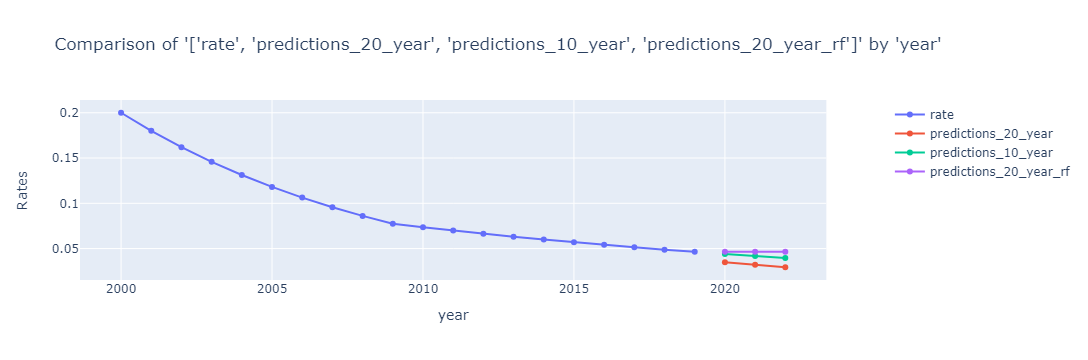

In [20]:
charters.compare_rates(
    model_data,
    x_axis="year",
    rates=[
        "rate",
        "predictions_20_year",
        "predictions_10_year",
        "predictions_20_year_tree",
    ],
)

## Partial Dependence

In [28]:
feature_dict = {
    "passthrough": ["year"],
}

In [29]:
preprocess_dict = preprocessors.preprocess_data(
    model_data,
    feature_dict=feature_dict,
    standardize=False,
)
mapping = preprocess_dict['mapping']

 2024-04-19 17:46:55 | morai.forecast.preprocessors | INFO     | passthrough - (generally numeric): ['year'] 


 2024-04-19 17:46:57 | morai.experience.charters | INFO     | Model: [DecisionTreeRegressor] for partial dependence plot. 
 2024-04-19 17:46:57 | morai.experience.charters | INFO     | x_axis: [year] type: [passthrough] 


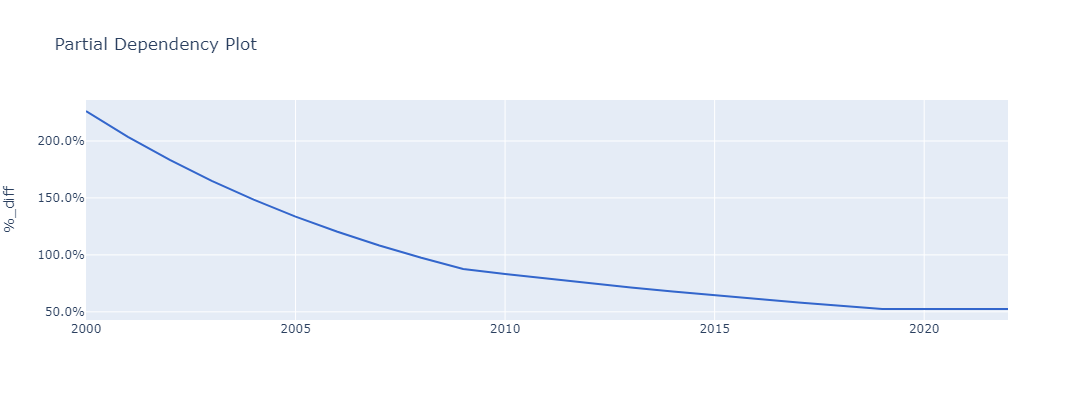

In [30]:
charters.pdp(
    model=model,
    df=model_data,
    x_axis="year",
    mapping=mapping,
    display=True,
)

 2024-04-19 17:46:28 | morai.experience.charters | INFO     | Model: [GLMResultsWrapper] for partial dependence plot. 
 2024-04-19 17:46:28 | morai.experience.charters | INFO     | x_axis: [year] type: [passthrough] 


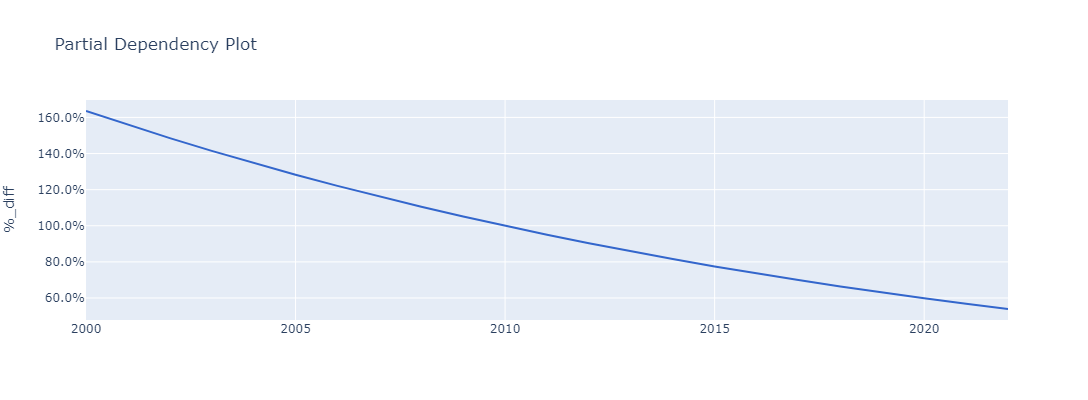

In [26]:
charters.pdp(
    model=GLM.model,
    df=model_data,
    x_axis="year",
    mapping=mapping,
    display=True,
)